## 1 Background
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. 

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

I will analyze an AB-test where we moved the first gate in Cookie Cats from gate/level 30 to gate/level 40. In particular, I will look at the impact on player retention. 

## 2 Initial Exploration

In [24]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/jasminechen/Downloads/cookie_cats.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [2]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


<p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>

#### When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40

In [3]:
# Counting the number of players in each AB group.
df.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

#### It looks like there is roughly the same number of players in each group, nice!

## 3 1-day Retention A/B Testing

In [4]:
# The % of users that came back the day after they installed
df['retention_1'].sum()/df['retention_1'].count()

0.4452095044850259

In [5]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].sum()/df.groupby('version')['retention_1'].count()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

#### For in 1-day retention, when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. I will use bootstrapping to repeatedly re-sample our dataset and calculate 1-day retention for those samples. The variation in 1-day retention will give an indication of how uncertain the retention numbers are.

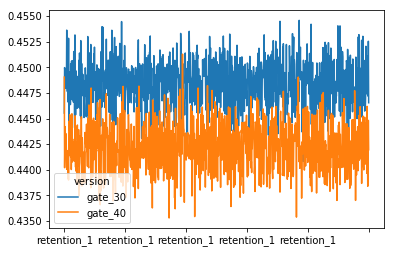

In [10]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot()

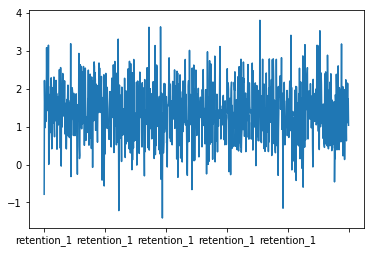

In [11]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot()

From this chart, we can see that the range of difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. 

In [12]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d['diff'])

# Pretty printing the probability
print(prob)

0.968


In [22]:
import statsmodels.api as sm

#Get gate30 
retention1_gate30 = df.query("version == 'gate_30' and retention_1 == True").shape[0]
n_gate30 = df.query("version == 'gate_30'").shape[0]

#Get gate40
retention1_gate40 = df.query("version == 'gate_40' and retention_1 == True").shape[0]
n_gate40 = df.query("version == 'gate_40'").shape[0]


In [25]:
# use stats.proportions_ztest to compute your test statistic and p-value.
count = np.array([retention1_gate30, retention1_gate40])
nobs = np.array([n_gate30, n_gate40])
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative = 'smaller')
print('{0:0.4f}'.format(z_score))
print('{0:0.4f}'.format(p_value))

1.7841
0.9628


## 4 7-day Retention A/B Testing

In [7]:
# overall 7-day retention rate 
df['retention_7'].sum()/df['retention_7'].count()

0.1860648194347426

In [8]:
# Calculating 7-day retention for each AB-group
df.groupby('version')['retention_7'].sum()/df.groupby('version')['retention_7'].count()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

<p>Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the <em>overall</em> 7-day retention is lower than the <em>overall</em> 1-day retention; fewer people play a game a week after installing than a day after installing.</p>


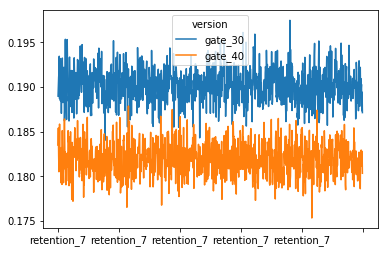

In [15]:
# Creating an list with bootstrapped means for each AB-group
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_7d.plot()

Text(0.5, 0, '% difference in means')

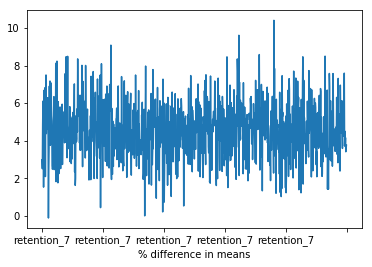

In [17]:
# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot()
ax.set_xlabel("% difference in means")


In [26]:
# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])

# Pretty printing the probability
print(prob)

0.998


In [27]:
#Get gate30 
retention7_gate30 = df.query("version == 'gate_30' and retention_7 == True").shape[0]
n_gate30 = df.query("version == 'gate_30'").shape[0]

#Get gate40
retention7_gate40 = df.query("version == 'gate_40' and retention_7 == True").shape[0]
n_gate40 = df.query("version == 'gate_40'").shape[0]

In [28]:
# use stats.proportions_ztest to compute your test statistic and p-value.
count1 = np.array([retention7_gate30, retention7_gate40])
nobs = np.array([n_gate30, n_gate40])
z_score, p_value = sm.stats.proportions_ztest(count1, nobs, alternative = 'smaller')
print('{0:0.4f}'.format(z_score))
print('{0:0.4f}'.format(p_value))

3.1644
0.9992


## 5 Conclusions

<p>The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should <strong>not</strong> move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.</p>
